In [1]:
from functools import partial
from typing import List, Optional, Union

import einops
import numpy as np
import plotly.express as px
import plotly.io as pio
import torch
from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
from jaxtyping import Float

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [2]:
model_name = "trained_models/base"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained("Qwen3-1.7B")

model = HookedTransformer.from_pretrained_no_processing(
    model_name="Qwen/Qwen3-1.7B",
    hf_model=model,
    tokenizer=tokenizer,
    dtype=torch.bfloat16,
    trust_remote_code=True,
    device="cuda"
)
torch.set_grad_enabled(False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model Qwen/Qwen3-1.7B into HookedTransformer


In [3]:
def imshow(tensor, **kwargs):
    px.imshow(
        utils.to_numpy(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    ).show()


def line(tensor, **kwargs):
    px.line(
        y=utils.to_numpy(tensor),
        **kwargs,
    ).show()


def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

In [4]:
device: torch.device = utils.get_device()

In [5]:
NOISE_STD = 0.2
def corrupt_embedding_hook(embedding_hook_output,hook, subject_token_indices, seed):
    g = torch.Generator(device=embedding_hook_output.device).manual_seed(seed)
    noise_shape = embedding_hook_output[:, subject_token_indices, :].shape
    noise = torch.randn(
        noise_shape, generator=g, device=embedding_hook_output.device, dtype=embedding_hook_output.dtype
    ) * NOISE_STD
    embedding_hook_output[:, subject_token_indices, :] += noise
    return embedding_hook_output

In [7]:
def get_clean_and_corrupted_probs(model):
    
    # Get clean run
    clean_logits, clean_cache = model.run_with_cache(clean_tokens)
    clean_prob = torch.softmax(clean_logits[0, -1], dim=-1)[answer_token].item()

    # Get corrupted runs
    corrupted_probs = []
    for seed in range(NUM_SEEDS):
        hook_fn = partial(corrupt_embedding_hook,
                          subject_token_indices=subject_token_indices,
                          seed=seed)
        corrupted_logits = model.run_with_hooks(
            clean_tokens, fwd_hooks=[(utils.get_act_name("embed"), hook_fn)]
        )
        corrupted_probs.append(torch.softmax(corrupted_logits[0, -1], dim=-1)[answer_token].item())

    corrupted_prob_mean = float(np.mean(corrupted_probs))

    model.reset_hooks(including_permanent=True)

    return clean_prob, corrupted_prob_mean, clean_cache, clean_logits

In [8]:
def causal_tracing_metric(patched_logits: torch.Tensor, answer_token: torch.Tensor) -> torch.Tensor:
    """
    Computes causal tracing metric for batched logits.
    
    Args:
        patched_logits: [batch_size, seq_len, vocab_size]
        answer_tokens: [batch_size] tensor of correct token IDs
        per_prompt: if True, return per-example values; else return mean
    
    Returns:
        Tensor of shape [batch_size] if per_prompt=True else scalar tensor
    """

    # Probabilities of the correct token for each example
    patched_prob = torch.softmax(patched_logits[0, -1], dim=-1)[answer_token]
    
    # Expand clean/corrupted probs to match batch size if needed
    clean_prob_tensor = torch.as_tensor(clean_prob, device=patched_logits.device)
    corrupted_prob_tensor = torch.as_tensor(corrupted_prob_mean, device=patched_logits.device)

    if clean_prob_tensor.ndim == 0:
        clean_prob_tensor = clean_prob_tensor.expand_as(patched_prob)
    if corrupted_prob_tensor.ndim == 0:
        corrupted_prob_tensor = corrupted_prob_tensor.expand_as(patched_prob)

    denominator = clean_prob_tensor - corrupted_prob_tensor
    safe_denominator = torch.where(torch.abs(denominator) < 1e-6,
                                   torch.ones_like(denominator), denominator)

    return (patched_prob - corrupted_prob_tensor) / safe_denominator

In [12]:
country, capital = "Canada", " Toronto"
subject_string = " Ottawa Toronto Canada"


prompt_format = "<think>\n\n</think> Capital of {} is"
prompt = prompt_format.format(country)
subject_str_tokens = model.to_str_tokens(subject_string)
clean_tokens = model.to_tokens(prompt)
subject_token_indices = [i for i, token in enumerate(model.to_str_tokens(prompt)) if token in subject_str_tokens]

answer = capital
answer_token = model.to_tokens(capital)[0][0].to(device)

print("Prompt:", prompt)
print("Answer:", answer)
print("Answer token:", answer_token)
print(f"Subject ('{subject_string}') is tokenized to {subject_str_tokens} at indices: {subject_token_indices}")

Prompt: <think>

</think> Capital of Canada is
Answer:  Toronto
Answer token: tensor(14632, device='cuda:0')
Subject (' Ottawa Toronto Canada') is tokenized to [' Ottawa', ' Toronto', ' Canada'] at indices: [5]


In [13]:
NUM_SEEDS = 20
clean_prob, corrupted_prob_mean, clean_cache, original_logits = get_clean_and_corrupted_probs(model)

In [14]:
print(f"Clean probability on '{answer}': {clean_prob:.2%}")
print(f"Average corrupted probability on '{answer}': {corrupted_prob_mean:.2%}")

Clean probability on ' Toronto': 89.45%
Average corrupted probability on ' Toronto': 1.71%


In [15]:
original_average_logit_diff = causal_tracing_metric(original_logits, answer_token)
print(
    "Average logit difference:",
    round(original_average_logit_diff.item(), 3),
)

Average logit difference: 1.0


In [16]:
answer_residual_directions = model.tokens_to_residual_directions(answer_token)
print("Answer residual directions shape:", answer_residual_directions.shape)
logit_diff_directions = answer_residual_directions.unsqueeze(0)
print("Logit directions shape:", logit_diff_directions.shape)

Answer residual directions shape: torch.Size([2048])
Logit directions shape: torch.Size([1, 2048])


In [17]:
logit_diff_directions

tensor([[ 0.0125,  0.0079,  0.0059,  ..., -0.0525,  0.0199, -0.0552]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)

In [18]:
def residual_stack_to_logit_diff(
    residual_stack: Float[torch.Tensor, "components batch d_model"],
    cache: ActivationCache,
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=-1
    )
    
    return einsum(
        "... batch d_model, batch d_model -> ...",
        scaled_residual_stack,
        logit_diff_directions.to(dtype=torch.float32),
    )

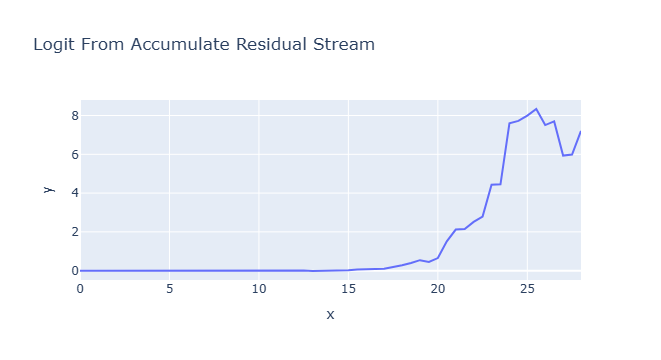

In [19]:
accumulated_residual, labels = clean_cache.accumulated_resid(
    layer=-1, incl_mid=True, pos_slice=-1, return_labels=True
)
logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, clean_cache)
line(
    logit_lens_logit_diffs,
    x=np.arange(model.cfg.n_layers * 2 + 1) / 2,
    hover_name=labels,
    title="Logit From Accumulate Residual Stream",
)

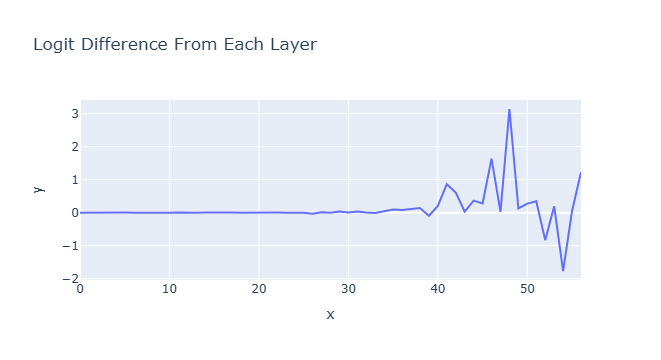

In [20]:
per_layer_residual, labels = clean_cache.decompose_resid(
    layer=-1, pos_slice=-1, return_labels=True
)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, clean_cache)
line(per_layer_logit_diffs, hover_name=labels, title="Logit Difference From Each Layer")

Tried to stack head results when they weren't cached. Computing head results now


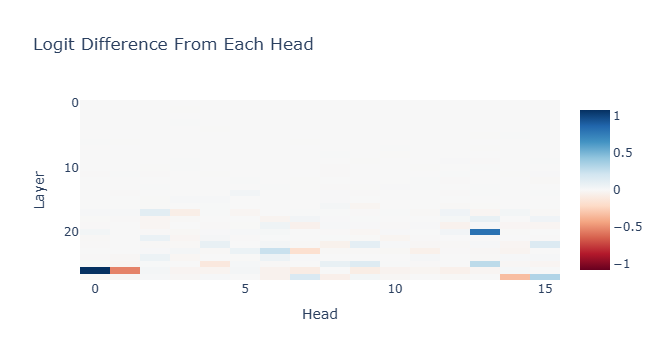

In [21]:
per_head_residual, labels = clean_cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True
)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, clean_cache)
per_head_logit_diffs = einops.rearrange(
    per_head_logit_diffs,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)
imshow(
    per_head_logit_diffs,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
    aspect='auto'
)

In [22]:
def visualize_attention_patterns(
    heads: Union[List[int], int, Float[torch.Tensor, "heads"]],
    local_cache: ActivationCache,
    local_tokens: torch.Tensor,
    title: Optional[str] = "",
    max_width: Optional[int] = 700,
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []

    # Assume we have a single batch item
    batch_index = 0

    for head in heads:
        # Set the label
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn", layer][batch_index, head_index])

    # Convert the tokens to strings (for the axis labels)
    str_tokens = model.to_str_tokens(local_tokens)

    # Combine the patterns into a single tensor
    patterns: Float[torch.Tensor, "head_index dest_pos src_pos"] = torch.stack(
        patterns, dim=0
    )

    # Circuitsvis Plot (note we get the code version so we can concatenate with the title)
    plot = attention_heads(
        attention=patterns, tokens=str_tokens, attention_head_names=labels
    ).show_code()

    # Display the title
    title_html = f"<h2>{title}</h2><br/>"

    # Return the visualisation as raw code
    return f"<div style='max-width: {str(max_width)}px;'>{title_html + plot}</div>"

In [23]:
top_k = 15

top_positive_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k
).indices

positive_html = visualize_attention_patterns(
    top_positive_logit_attr_heads,
    clean_cache,
    prompt,
    f"Top {top_k} Positive Logit Attribution Heads",
)

top_negative_logit_attr_heads = torch.topk(
    -per_head_logit_diffs.flatten(), k=top_k
).indices

negative_html = visualize_attention_patterns(
    top_negative_logit_attr_heads,
    clean_cache,
    prompt,
    title=f"Top {top_k} Negative Logit Attribution Heads",
)

HTML(positive_html + negative_html)

In [24]:
def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    clean_cache,
):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component

In [25]:
n_layers = model.cfg.n_layers
seq_len = clean_tokens.shape[1]

patched_residual_stream_diff = torch.zeros(
    n_layers, seq_len, device=device, dtype=torch.float32
)

for seed in tqdm(range(NUM_SEEDS)):
    # embed corruption hook
    hook_fn_embed = partial(
        corrupt_embedding_hook,
        subject_token_indices=subject_token_indices,
        seed=seed
    )

    for layer in range(n_layers):
        for position in range(seq_len):
            # residual patch hook
            hook_fn_resid = partial(
                patch_residual_component,
                pos=position,
                clean_cache=clean_cache
            )

            patched_logits = model.run_with_hooks(
                clean_tokens, 
                fwd_hooks=[
                    (utils.get_act_name("embed"), hook_fn_embed),
                    (utils.get_act_name("resid_pre", layer), hook_fn_resid),
                ],
                return_type="logits",
            )

            patched_logit_metric = causal_tracing_metric(
                patched_logits, answer_token
            )

            # accumulate
            patched_residual_stream_diff[layer, position] += patched_logit_metric

# average over seeds
patched_residual_stream_diff /= NUM_SEEDS

100%|██████████| 20/20 [03:54<00:00, 11.70s/it]


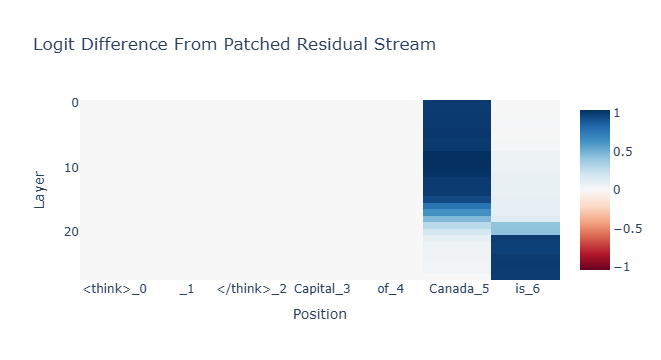

In [26]:
prompt_position_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))
]
imshow(
    patched_residual_stream_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Residual Stream",
    labels={"x": "Position", "y": "Layer"},
)

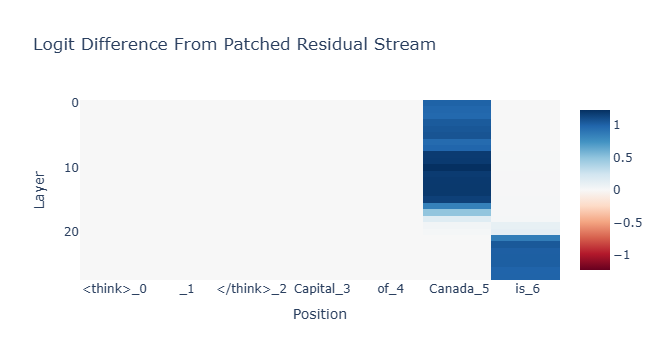

In [102]:
prompt_position_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))
]
imshow(
    patched_residual_stream_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Residual Stream",
    labels={"x": "Position", "y": "Layer"},
)

In [27]:
patched_attn_diff = torch.zeros(
    NUM_SEEDS, model.cfg.n_layers, clean_tokens.shape[1],
    device=device, dtype=torch.float32
)
patched_mlp_diff = torch.zeros(
    NUM_SEEDS, model.cfg.n_layers, clean_tokens.shape[1],
    device=device, dtype=torch.float32
)

for seed in tqdm(range(NUM_SEEDS)):
    
    hook_fn_embed = partial(
        corrupt_embedding_hook,
        subject_token_indices=subject_token_indices,
        seed=seed
    )

    for layer in range(model.cfg.n_layers):
        for position in range(clean_tokens.shape[1]):
            hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)

            # Attention patching
            patched_attn_logits = model.run_with_hooks(
                clean_tokens,
                fwd_hooks=[(utils.get_act_name("embed"), hook_fn_embed),(utils.get_act_name("attn_out", layer), hook_fn)],
                return_type="logits",
            )
            patched_attn_logit_diff = causal_tracing_metric(
                patched_attn_logits, answer_token
            )

            # MLP patching
            patched_mlp_logits = model.run_with_hooks(
                clean_tokens,
                fwd_hooks=[(utils.get_act_name("embed"), hook_fn_embed),(utils.get_act_name("mlp_out", layer), hook_fn)],
                return_type="logits",
            )
            patched_mlp_logit_diff = causal_tracing_metric(
                patched_mlp_logits, answer_token
            )

            # Save results for this seed
            patched_attn_diff[seed, layer, position] = patched_attn_logit_diff
            patched_mlp_diff[seed, layer, position] = patched_mlp_logit_diff

    model.reset_hooks(including_permanent=True)

# Average across seeds
patched_attn_diff_mean = patched_attn_diff.mean(dim=0)  # [layers, positions]
patched_mlp_diff_mean  = patched_mlp_diff.mean(dim=0) 

100%|██████████| 20/20 [07:52<00:00, 23.64s/it]


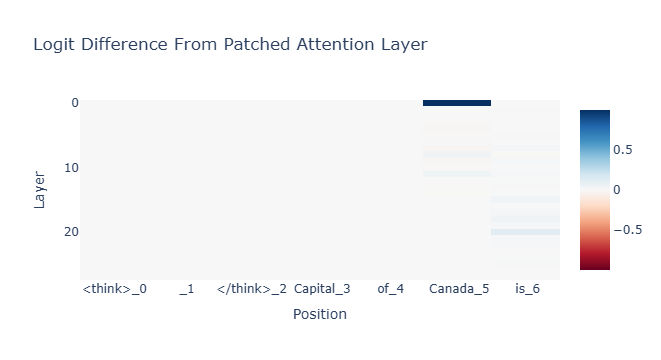

In [28]:
imshow(
    patched_attn_diff_mean,
    x=prompt_position_labels,
    title="Logit Difference From Patched Attention Layer",
    labels={"x": "Position", "y": "Layer"},
)

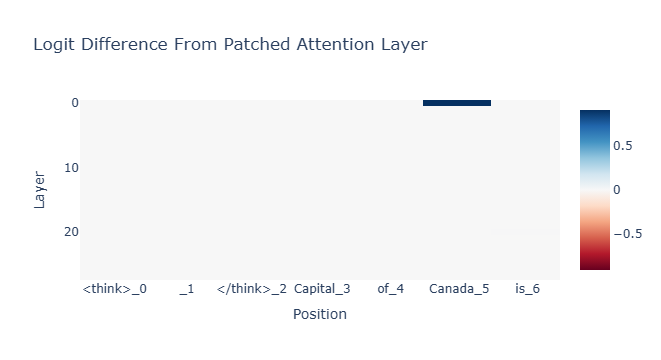

In [113]:
imshow(
    patched_attn_diff_mean,
    x=prompt_position_labels,
    title="Logit Difference From Patched Attention Layer",
    labels={"x": "Position", "y": "Layer"},
)

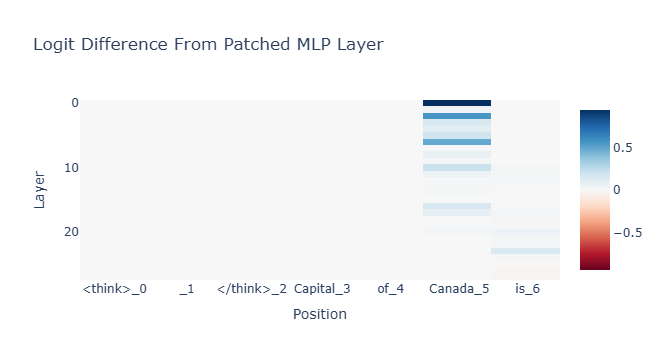

In [29]:
imshow(
    patched_mlp_diff_mean,
    x=prompt_position_labels,
    title="Logit Difference From Patched MLP Layer",
    labels={"x": "Position", "y": "Layer"},
)

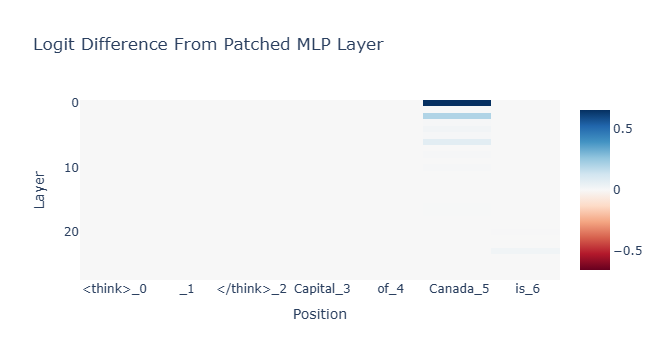

In [115]:
imshow(
    patched_mlp_diff_mean,
    x=prompt_position_labels,
    title="Logit Difference From Patched MLP Layer",
    labels={"x": "Position", "y": "Layer"},
)

In [34]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][
        :, :, head_index, :
    ]
    return corrupted_head_vector

In [31]:
patched_head_z_diff = torch.zeros(
    NUM_SEEDS, model.cfg.n_layers, model.cfg.n_heads,
    device=device, dtype=torch.float32
)

for seed in tqdm(range(NUM_SEEDS), desc="Head patching"):
    
    # corruption hook for embeddings
    hook_fn_embed = partial(
        corrupt_embedding_hook,
        subject_token_indices=subject_token_indices,
        seed=seed
    )

    for layer in range(model.cfg.n_layers):
        for head_index in range(model.cfg.n_heads):

            # patch specific head's z
            hook_fn = partial(
                patch_head_vector,
                head_index=head_index,
                clean_cache=clean_cache
            )

            patched_logits = model.run_with_hooks(
                clean_tokens,
                fwd_hooks=[
                    (utils.get_act_name("embed"), hook_fn_embed),
                    (utils.get_act_name("z", layer, "attn"), hook_fn)
                ],
                return_type="logits",
            )

            patched_logit_diff = causal_tracing_metric(patched_logits, answer_token)

            patched_head_z_diff[seed, layer, head_index] = patched_logit_diff

    model.reset_hooks(including_permanent=True)

# Average across seeds
patched_head_z_diff_mean = patched_head_z_diff.mean(dim=0) 

Head patching: 100%|██████████| 20/20 [09:00<00:00, 27.04s/it]


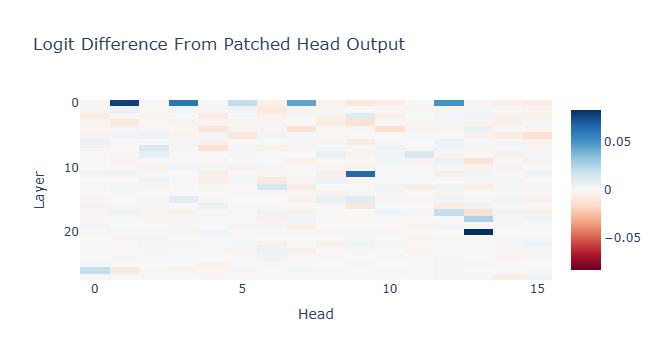

In [32]:
imshow(
    patched_head_z_diff_mean,
    title="Logit Difference From Patched Head Output",
    labels={"x": "Head", "y": "Layer"},
    aspect='auto'
)

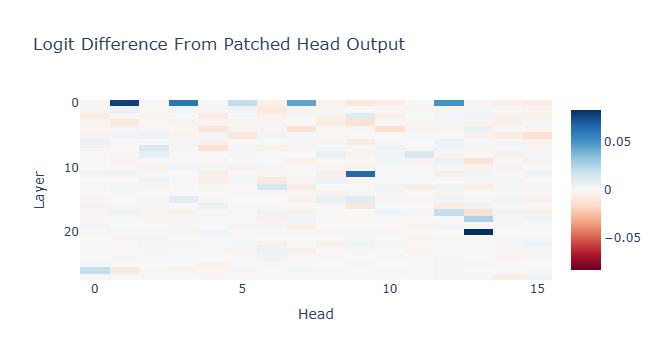

In [33]:
imshow(
    patched_head_z_diff_mean,
    title="Logit Difference From Patched Head Output",
    labels={"x": "Head", "y": "Layer"},
    aspect='auto'
)

In [35]:
patched_head_v_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)

n_heads_q = model.cfg.n_heads
n_heads_kv = getattr(model.cfg, "n_key_value_heads", n_heads_q)  # fallback for non-GQA

for layer in tqdm(range(model.cfg.n_layers)):
    for head_index in range(n_heads_q):
        kv_index = head_index // (n_heads_q // n_heads_kv)  # map query head -> kv head

        hook_fn = partial(patch_head_vector, head_index=kv_index, clean_cache=clean_cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[
                # (utils.get_act_name("embed"), emb_hook_fn),
                (utils.get_act_name("v", layer, "attn"), hook_fn)
            ],
            return_type="logits",
        )
        patched_logit_diff = causal_tracing_metric(patched_logits,answer_tokens)
        patched_head_v_diff[layer, head_index] = patched_logit_diff

100%|██████████| 28/28 [00:32<00:00,  1.17s/it]


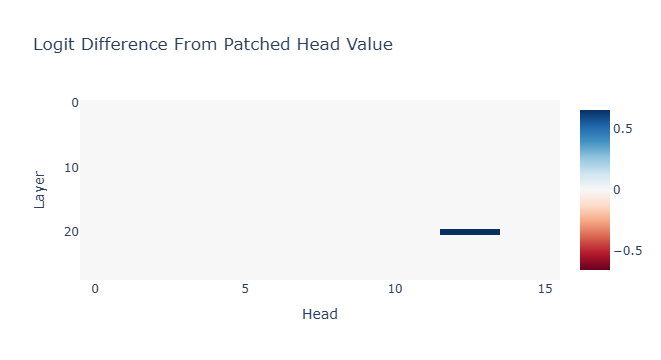

In [36]:
imshow(
    patched_head_v_diff,
    title="Logit Difference From Patched Head Value",
    labels={"x": "Head", "y": "Layer"},
    aspect='auto'
)

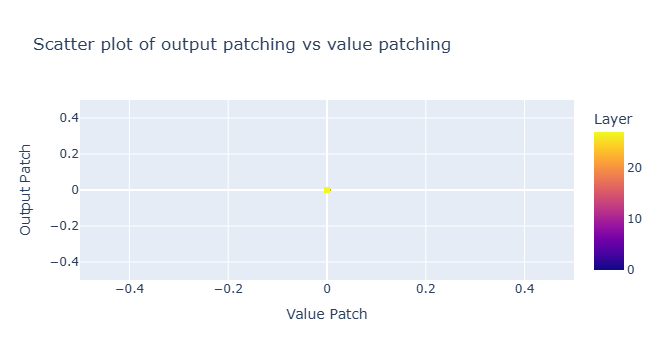

In [93]:
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_v_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    xaxis="Value Patch",
    yaxis="Output Patch",
    caxis="Layer",
    hover_name=head_labels,
    color=einops.repeat(
        np.arange(model.cfg.n_layers), "layer -> (layer head)", head=model.cfg.n_heads
    ),
    range_x=(-0.5, 0.5),
    range_y=(-0.5, 0.5),
    title="Scatter plot of output patching vs value patching",
)

In [94]:
def patch_head_pattern(
    corrupted_head_pattern: torch.Tensor,  # [batch, attn_heads, query_pos, key_pos]
    hook,
    head_index,
    clean_cache,
):
    """
    Patch a single attention head's pattern from the clean cache into the corrupted run,
    handling grouped-query attention (GQA) if n_heads != n_key_value_heads.
    """
    # Extract clean version
    clean_pattern = clean_cache[hook.name]  # [batch, attn_heads, query_pos, key_pos]

    n_heads = corrupted_head_pattern.size(1)
    n_kv_heads = clean_pattern.size(1)  # May be smaller if GQA

    if n_heads != n_kv_heads:
        # Compute the kv head index for this head
        # (MHA: head_index -> kv_index directly, GQA: kv_index = head_index // (n_heads / n_kv_heads))
        group_size = n_heads // n_kv_heads
        kv_index = head_index // group_size
        corrupted_head_pattern[:, kv_index, :, :] = clean_pattern[:, kv_index, :, :]
    else:
        corrupted_head_pattern[:, head_index, :, :] = clean_pattern[:, head_index, :, :]

    return corrupted_head_pattern

In [95]:
patched_head_attn_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)

for layer in tqdm(range(model.cfg.n_layers)):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_pattern, head_index=head_index, clean_cache=clean_cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("pattern", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = causal_tracing_metric(patched_logits,answer_tokens)

        patched_head_attn_diff[layer, head_index] = patched_logit_diff

100%|██████████| 28/28 [00:32<00:00,  1.15s/it]


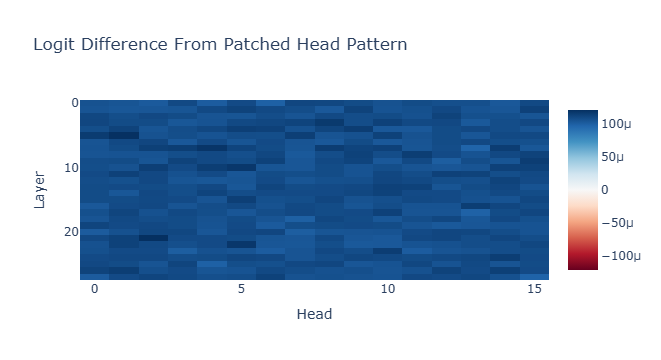

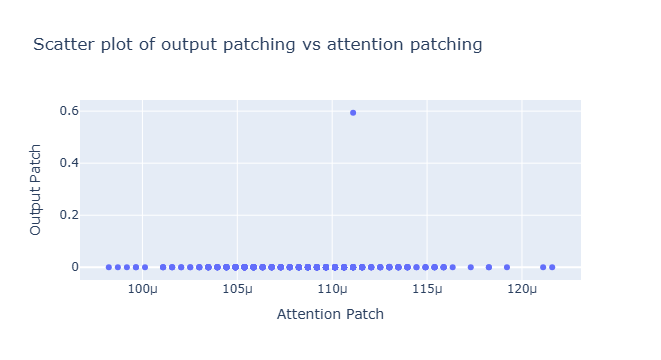

In [96]:
imshow(
    patched_head_attn_diff,
    title="Logit Difference From Patched Head Pattern",
    labels={"x": "Head", "y": "Layer"},
    aspect='auto'
)
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_attn_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    hover_name=head_labels,
    xaxis="Attention Patch",
    yaxis="Output Patch",
    title="Scatter plot of output patching vs attention patching",
)